In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import scipy
import scipy.integrate
from scipy.integrate import quad
from scipy.optimize import minimize 
from datetime import datetime as dt
from scipy.stats import norm


Load the functions needed for calibrating the heston model.

def heston_charfunc(phi, S0, v0, kappa, theta, sigma, rho, tau, r):
    # constants
    lambd=0
    a = kappa*theta
    b = kappa+lambd
    
    # common terms w.r.t phi
    rspi = rho*sigma*phi*1j
    
    # define d parameter given phi and b
    d = np.sqrt( (rho*sigma*phi*1j - b)**2 + (phi*1j+phi**2)*sigma**2 )
    
    # define g parameter given phi, b and d
    g = (b-rspi+d)/(b-rspi-d)
    
    # calculate characteristic function by components
    exp1 = np.exp(r*phi*1j*tau)
    term2 = S0**(phi*1j) * ( (1-g*np.exp(d*tau))/(1-g) )**(-2*a/sigma**2)
    exp2 = np.exp(a*tau*(b-rspi+d)/sigma**2 + v0*(b-rspi+d)*( (1-np.exp(d*tau))/(1-g*np.exp(d*tau)) )/sigma**2)
    return exp1*term2*exp2


def integrand(phi, S0, v0, kappa, theta, sigma, rho, tau, r, K):
    args = (S0, v0, kappa, theta, sigma, rho, tau, r)
    numerator = np.exp(r*tau)*heston_charfunc(phi-1j,*args) - K*heston_charfunc(phi,*args)
    denominator = 1j*phi*K**(1j*phi)
    return numerator/denominator
    
        
def heston_price(S0, K, v0, kappa, theta, sigma, rho, tau, r):
    real_integral = []
    err = []
    for index in range(0,len(S0)):
        args = (S0[index], v0, kappa, theta, sigma, rho, tau[index], r[index], K[index])
        
        a, b = np.real( quad(integrand, 0, 200, args=args) )
        real_integral = real_integral+ [a]
        err = err + [b]

    return (S0 - K*np.exp(-r*tau))/2 + np.divide(real_integral, np.pi)


def RtSqErr(x):
    '''
    Loss function (root mean square error)
    '''
    v0, kappa, theta, sigma, rho = [param for param in x]
    
    err = np.sqrt( np.sum( (P-heston_price(S0, K, v0, kappa, theta, sigma, rho, tau, r))**2 /len(P) ))
    
    return err 

################################################################
'''
Returns the Price of a Black Schole Call Option

Args:
    S - initial path value
    K - Strike Price
    T - time to maturity
    sigma - volatility parameter
    r - risk free rate
'''

def d1(S, K, T, r, sigma):
    return (np.log(S/K) + (r + sigma**2/2.)*T)/(sigma*np.sqrt(T))

def d2(S, K, T, r, sigma):
    return d1(S,K,T,r,sigma)-sigma*np.sqrt(T)

def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*np.exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))

def bs_put(S,K,T,r,sigma):
    return -S*norm.cdf(-d1(S,K,T,r,sigma))+K*np.exp(-r*T)*norm.cdf(-d2(S,K,T,r,sigma))


def bs_mse(sigma, table, maturity):
    '''
    Returns the Mean square error for a given estimated volatility for Black Scholes to the call option price 
    
    Args:
        sigma - volatility parameter
        table - implied volatility table
        maturity - time to maturity
    '''
    error = 0
    for col in table.columns:
        mat = 0
        mat_string = col.split("VOL ")[1]
        if mat_string == maturity:
            mat_number = mat_string.split()[0]
            mat_unit = mat_string.split()[1]
            mat = int(mat_number)
            if mat_unit == "MTH." :
               mat = mat / 12
            # split string at whitespace. Find which substring contains a % and return that substring.
            moneyness_string = col.split()[[idx for idx, s in enumerate(df_vol.columns[0].split()) if '%' in s][0]]
            moneyness = int(moneyness_string[:-1]) / 100
            volatility =  table[col] / 100
            error = error + (bs_call(S=1,K=moneyness,T=mat,r=0,sigma=volatility) - bs_call(S=1,K=moneyness,T=mat,r=0,sigma=sigma))**2
    return np.sqrt(error/len(error))

################################################################

def extractDataFromTable(table, maturities):
    '''
    
    '''
    #S0   = lastTradePrice
    #r    = rate
    #K    = strike
    #tau  = maturity
    #P    = price
    
    # Select which maturities we want to use
    #maturities=["2 YR .", "1 YR .","9 MTH.","6 MTH.","3 MTH." ,"1 MTH."]
    # Select the row/s to get data from
    #table = df_vol.loc["2013-05-24":"2013-05-24"]
    
    
    length = 0
    tau = np.empty(0,dtype=float)
    K = np.empty(0,dtype=float)
    P = np.empty(0,dtype=float)
    
    for col in table.columns:
            mat = 0
            mat_string = col.split("VOL ")[1]
            for maturity in maturities:
                if mat_string == maturity:
    
                    mat_number = mat_string.split()[0]
                    mat_unit = mat_string.split()[1]
                    mat = int(mat_number)
                    if mat_unit == "MTH." :
                       mat = mat / 12
                    # split string at whitespace. Find which substring contains a % and return that substring.
                    moneyness_string = col.split()[[idx for idx, s in enumerate(df_vol.columns[0].split()) if '%' in s][0]]
                    moneyness = int(moneyness_string[:-1]) / 100
                    volatility =  table[col] / 100
                    length = length + 1
                    for row in table.index:
                        tau = np.append(tau,mat)
                        K = np.append(K,moneyness)
                        P = np.append(P,bs_call(100,moneyness*100,mat,0,table[col][row] / 100))
    
    
    S0 = np.ones(len(tau),dtype=float)*100
    r = np.zeros(len(tau),dtype=float)
    return S0, r, K*S0, tau, P

Import Implied volatilities of S&P 500 exported from Thomson Reuters Eikon

In [3]:
df_vol = pd.read_excel("SP500_implied_volatilities.xlsx", index_col=0)

Calibration of Black-Scholes

In [ ]:
init_guess =.5
scipy.optimize.fmin(bs_mse, init_guess, args=(df_vol.loc[["2016-06-20"]],"1 YR ."))

Inital calibration of Heston model with all maturities.

In [ ]:
# Parameters are v0, kappa, theta, sigma, rho, lambd
# Define variables to be used in optimization

S0, r, K, tau, P = extractDataFromTable(df_vol.loc["2016-06-20":"2016-06-20"], ["2 YR .", "1 YR .","9 MTH.","6 MTH.","3 MTH." ,"2 MTH.", "1 MTH."])

# Parameters and inital guesses
params = {"v0": {"x0": 0.02, "lbub": [1e-3,0.1]}, 
          "kappa": {"x0": 1.6, "lbub": [0.1,5]},
          "theta": {"x0": 0.05, "lbub": [1e-3,0.2]},
          "sigma": {"x0": 0.6, "lbub": [1e-2,1]},
          "rho": {"x0": -0.6, "lbub": [-1,0]}
          }
x0 = [param["x0"] for key, param in params.items()]
bnds = [param["lbub"] for key, param in params.items()]


result = minimize(RtSqErr, x0, tol = 1e-7, method='SLSQP', options={'maxiter': 1e5 }, bounds=bnds)

v0, kappa, theta, sigma, rho = [param for param in result.x]


Set kappa fixed and recalibrate with only maturity one year.'

In [ ]:
kappa_fixed = kappa


S0, r, K, tau, P = extractDataFromTable(df_vol.loc["2016-06-20":"2016-06-20"], ["1 YR ."])

# Parameters and inital guesses
params = {"v0": {"x0": v0, "lbub": [1e-3,0.1]}, 
          "kappa": {"x0":kappa_fixed, "lbub": [kappa_fixed,kappa_fixed]},
          "theta": {"x0": theta, "lbub": [1e-3,0.1]},
          "sigma": {"x0": sigma, "lbub": [1e-2,1]},
          "rho": {"x0": rho, "lbub": [-1,0]}
          }
x0 = [param["x0"] for key, param in params.items()]
bnds = [param["lbub"] for key, param in params.items()]


result = minimize(RtSqErr, x0, tol = 1e-12, method='SLSQP', options={'maxiter': 1e4 }, bounds=bnds)

v0, kappa, theta, sigma, rho = [param for param in result.x]


Resulting values of the calibration:

In [28]:
v0, kappa, theta, sigma, rho = (0.029547539464075276, 0.4666888846590575, 0.09999999999999999, 0.4999266234077456, -0.8598476317638354)

In [31]:
def change_var(x, value, use_v0, use_theta, use_sigma):
    v0, kappa, theta, sigma, rho = x
    if use_v0:
        return [value, kappa, theta, sigma, rho]
    elif use_theta:
        return [v0, kappa, value, sigma, rho]
    elif use_sigma:
        return [v0, kappa, theta, value, rho]


def find_x_where_error_equals_y(startpoint, error_whish, use_v0, use_theta, use_sigma, x, stepsize = 0.0001):
    cur_error = RtSqErr(x)
    x_left = startpoint
    while(cur_error < error_whish):
        x_left = x_left - stepsize
        cur_error = RtSqErr(change_var(x, x_left, use_v0, use_theta, use_sigma))
    cur_error = RtSqErr(x)
    x_right = startpoint
    while(cur_error < error_whish):
        x_right = x_right + stepsize
        cur_error = RtSqErr(change_var(x, x_right, use_v0, use_theta, use_sigma))
    return x_left, x_right

/home/skalinux/miniconda3/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:577: ComplexWarning:

Casting complex values to real discards the imaginary part



0.029037539464075297 0.030057539464075255


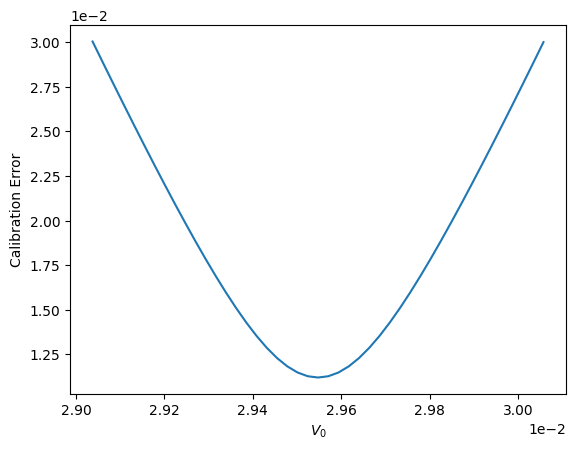

In [46]:
x = [v0, kappa_fixed, theta, sigma, rho]
x_min, x_max = find_x_where_error_equals_y(v0, 3e-2, True, False, False, x, 0.00001)
v_grid = np.linspace(x_min, x_max, 45)
hest_mse_v = []

table=df_vol.loc[["2016-06-20"]]
maturities=["1 YR ."]
S0, r, K, tau, P = extractDataFromTable(table, maturities)



for v_iter in v_grid:
    #hest_mse_v.append(heston_mse(kappa, theta, sigma_v, rho, v_iter, table, maturities))
    x = [v_iter, kappa_fixed, theta, sigma, rho]
    hest_mse_v.append(RtSqErr(x))
    
fig = plt.figure()
plt.ticklabel_format(axis='both', style='sci', scilimits=(2,-5))
plt.xlabel(r"$V_0$")
plt.ylabel("Calibration Error")
plt.plot(v_grid,hest_mse_v)
#plt.savefig('v_0.png')
fig.savefig(THESIS_IMG_PATH+'/v0.pgf', backend='pgf',bbox_inches='tight')

print(x_min, x_max)



/home/skalinux/miniconda3/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:577: ComplexWarning:

Casting complex values to real discards the imaginary part



0.09833000000000064 0.10168999999999934


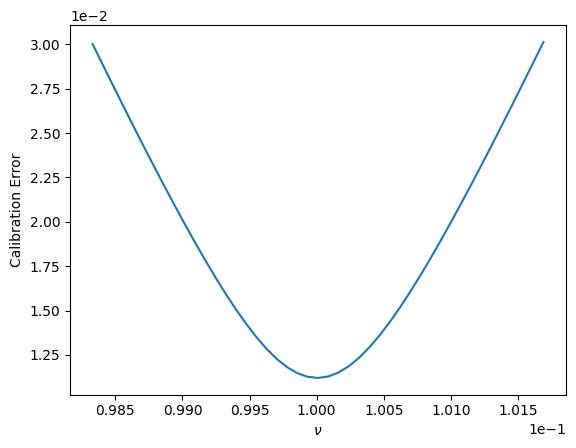

In [48]:
x = [v0, kappa_fixed, theta, sigma, rho]
x_min, x_max = find_x_where_error_equals_y(theta, 3e-2, False, True, False, x, 0.00001)
theta_grid = np.linspace(x_min, x_max, 45)

hest_mse_theta = []

table=df_vol.loc[["2016-06-20"]]
maturities=["1 YR ."]
S0, r, K, tau, P = extractDataFromTable(table, maturities)

for theta_iter in theta_grid:
    x = [v0, kappa_fixed, theta_iter, sigma, rho]
    hest_mse_theta.append(RtSqErr(x))
fig = plt.figure()

plt.ticklabel_format(axis='both', style='sci', scilimits=(2,-5))

plt.plot(theta_grid,hest_mse_theta)
plt.xlabel(r"$\nu$")
plt.ylabel("Calibration Error")
fig.savefig(THESIS_IMG_PATH+'/nu.pgf', backend='pgf',bbox_inches='tight')
print(x_min, x_max)

/home/skalinux/miniconda3/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:577: ComplexWarning:

Casting complex values to real discards the imaginary part



0.49102662340774655 0.5089266234077446


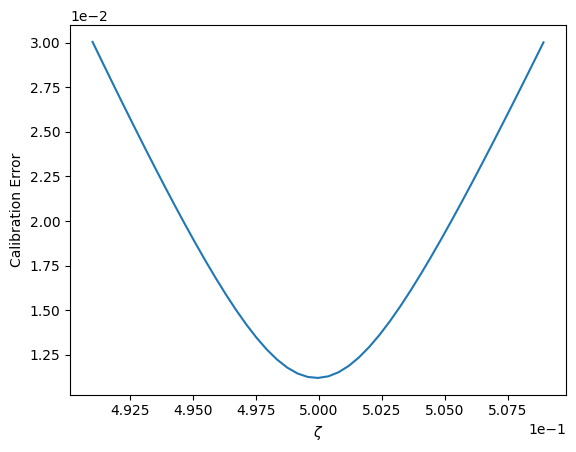

In [49]:
x = [v0, kappa_fixed, theta, sigma, rho]
x_min, x_max = find_x_where_error_equals_y(sigma, 3e-2, False, False, True, x)
sigma_grid = np.linspace(x_min, x_max, 45)
hest_mse_sigma = []

table=df_vol.loc[["2016-06-20"]]
maturities=["1 YR ."]
S0, r, K, tau, P = extractDataFromTable(table, maturities)

for sigma_iter in sigma_grid:
    x = [v0, kappa_fixed, theta, sigma_iter, rho]
    hest_mse_sigma.append(RtSqErr(x))
fig = plt.figure()

plt.ticklabel_format(axis='both', style='sci', scilimits=(2,-5))
plt.xlabel(r"$\zeta$")
plt.ylabel("Calibration Error")
plt.plot(sigma_grid,hest_mse_sigma)
fig.savefig(THESIS_IMG_PATH+'/zeta.pgf', backend='pgf',bbox_inches='tight')
print(x_min, x_max)

In [50]:
table=df_vol.loc[["2016-06-20"]]
maturities=["1 YR ."]
S0, r, K, tau, P = extractDataFromTable(table, maturities)
hest_mse_theta_v = []

for v_iter in v_grid:
    for theta_iter in theta_grid:
        x = [v_iter, kappa_fixed, theta_iter, sigma, rho]
        hest_mse_theta_v.append(RtSqErr(x))

hest_mse_theta_v = np.reshape(hest_mse_theta_v, (len(theta_grid),len(v_grid)))

/home/skalinux/miniconda3/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:577: ComplexWarning:

Casting complex values to real discards the imaginary part



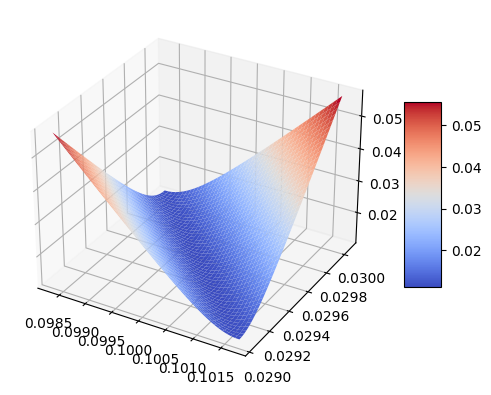

In [24]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')


#ax = fig.gca(projection='3d')
X, Y = np.meshgrid(theta_grid, v_grid)
Z = hest_mse_theta_v

surf = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, cmap=cm.coolwarm, 
                linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)

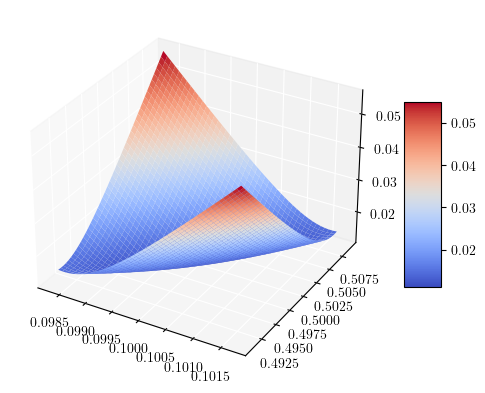

In [64]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')


#ax = fig.gca(projection='3d')
X, Y = np.meshgrid(theta_grid, sigma_grid)
Z = hest_mse_theta_sigma

surf = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, cmap=cm.coolwarm, 
                linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)

In [65]:
table=df_vol.loc[["2016-06-20"]]
maturities=["1 YR ."]
S0, r, K, tau, P = extractDataFromTable(table, maturities)
hest_mse_v_sigma = []

for sigma_iter in sigma_grid:
    for v_iter in v_grid:
        x = [v_iter, kappa_fixed, theta, sigma_iter, rho]
        hest_mse_v_sigma.append( RtSqErr(x))

hest_mse_v_sigma = np.reshape(hest_mse_v_sigma, (len(v_grid),len(sigma_grid)))

/home/skalinux/miniconda3/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:577: ComplexWarning:

Casting complex values to real discards the imaginary part



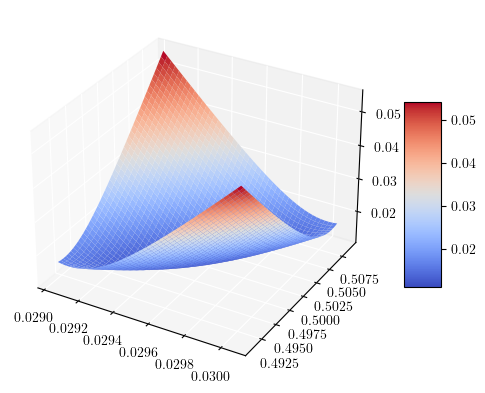

In [66]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')


X, Y = np.meshgrid(v_grid, sigma_grid)
Z = hest_mse_v_sigma

surf = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, cmap=cm.coolwarm, 
                linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)

/tmp/ipykernel_86/3720200521.py:38: MatplotlibDeprecationWarning:

The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.

/tmp/ipykernel_86/3720200521.py:39: MatplotlibDeprecationWarning:

The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.

/tmp/ipykernel_86/3720200521.py:40: MatplotlibDeprecationWarning:

The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.



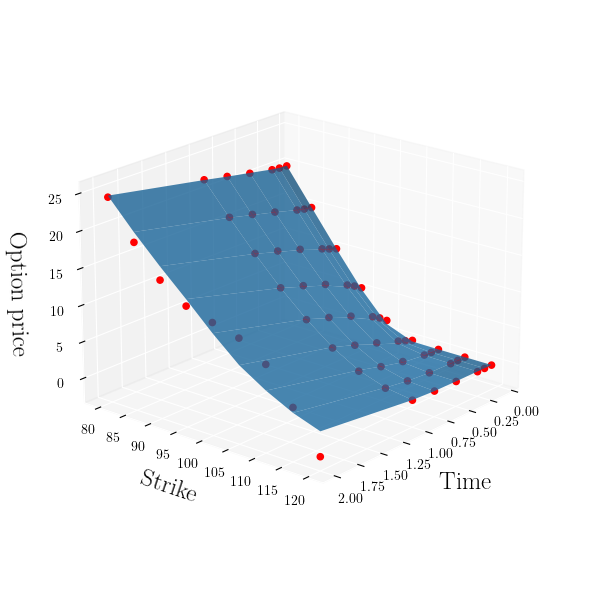

In [245]:
plt.rcParams.update({
    "font.family": "serif",
    # Use LaTeX default serif font.
    "font.serif": [],
    # Use specific cursive fonts.
    "font.cursive": ["Comic Neue", "Comic Sans MS"],
    "text.usetex": True, 
#    "pgf.rcfonts": False, 
#    'text.latex.preamble': r'\newcommand{\mathdefault}[1][]{}'

})
plt.rcParams['grid.color'] = "white"


fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

#X, Y = np.meshgrid(np.unique(tau), np.unique(K))
X = np.reshape(tau,(9,7))
Y = np.reshape(K,(9,7))
Z = np.reshape(P,(9,7))

X = np.sort(X,axis=1)
Z = Z[:,[0,2,4,5,6,1,3]]

alphas = np.ones((9,7))
alphas2 = alphas*.5
Z2 = np.reshape(heston_prices,(9,7))

surf = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, 
                linewidth=0.1, alpha=.8)
ax.set_facecolor('white')
ax.scatter(X,Y,Z2[:,[0,2,4,5,6,1,3]], color="red", alpha=alphas)

ax.set_xlabel(r"Time", fontsize=18, labelpad=14)
ax.set_ylabel(r"Strike", fontsize=18, labelpad=10)
ax.set_zlabel(r"Option price", fontsize=18, labelpad=10)
ax.w_xaxis.line.set_color("white")
ax.w_yaxis.line.set_color("white")
ax.w_zaxis.line.set_color("white")


plt.tight_layout()
ax.set_box_aspect(aspect=None, zoom=0.85)
ax.view_init(20, 40)
plt.show()
THESIS_IMG_PATH = "/mnt/c/Users/Skatower/OneDrive - bwedu/Masterarbeit/Dokumentation/masterarbeit/images"
fig.savefig(THESIS_IMG_PATH+'/ModelFit.pgf', backend='pgf',bbox_inches='tight')

Generation of a dataframe conatining the error for all combinations

In [296]:
rows = []
for v_iter in v_grid:
    for sigma_iter in sigma_grid:
        for theta_iter in theta_grid:
            x = [v_iter, kappa_fixed, theta_iter, sigma_iter, rho]
            
            rows.append([v_iter, sigma_iter, theta_iter, RtSqErr(x)])

In [ ]:
y =[]
for i in range(len(rows)):
    y.append(9*(1+np.log(2*np.pi)+np.log(rows[i,-1]**2))+2*(5+1))
x = y-np.min(y)
num = np.exp(-x/2)
dom = np.sum(num)
prob = num/dom
rows=np.append(rows,np.vstack(prob),axis=1)

pd_rows = pd.DataFrame(rows)
pd_rows.to_csv('AIC_int.csv',index=False)